In [1]:
import os
import argparse
from tqdm import tqdm

import torch
import numpy as np
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt

from generate_samples_batch import Diffsound
from specvqgan.modules.losses.vggishish.transforms import Crop

/home/yoonjin/anaconda3/envs/ttss2/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/yoonjin/anaconda3/envs/ttss2/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import math
from torch.optim.lr_scheduler import _LRScheduler

class CosineAnnealingWarmUpRestarts(_LRScheduler):
    def __init__(self, optimizer, T_0, T_mult=1, eta_max=0.1, T_up=0, gamma=1., last_epoch=-1):
        if T_0 <= 0 or not isinstance(T_0, int):
            raise ValueError("Expected positive integer T_0, but got {}".format(T_0))
        if T_mult < 1 or not isinstance(T_mult, int):
            raise ValueError("Expected integer T_mult >= 1, but got {}".format(T_mult))
        if T_up < 0 or not isinstance(T_up, int):
            raise ValueError("Expected positive integer T_up, but got {}".format(T_up))
        self.T_0 = T_0
        self.T_mult = T_mult
        self.base_eta_max = eta_max
        self.eta_max = eta_max
        self.T_up = T_up
        self.T_i = T_0
        self.gamma = gamma
        self.cycle = 0
        self.T_cur = last_epoch
        super(CosineAnnealingWarmUpRestarts, self).__init__(optimizer, last_epoch)
    
    def get_lr(self):
        if self.T_cur == -1:
            return self.base_lrs
        elif self.T_cur < self.T_up:
            return [(self.eta_max - base_lr)*self.T_cur / self.T_up + base_lr for base_lr in self.base_lrs]
        else:
            return [base_lr + (self.eta_max - base_lr) * (1 + math.cos(math.pi * (self.T_cur-self.T_up) / (self.T_i - self.T_up))) / 2
                    for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
            self.T_cur = self.T_cur + 1
            if self.T_cur >= self.T_i:
                self.cycle += 1
                self.T_cur = self.T_cur - self.T_i
                self.T_i = (self.T_i - self.T_up) * self.T_mult + self.T_up
        else:
            if epoch >= self.T_0:
                if self.T_mult == 1:
                    self.T_cur = epoch % self.T_0
                    self.cycle = epoch // self.T_0
                else:
                    n = int(math.log((epoch / self.T_0 * (self.T_mult - 1) + 1), self.T_mult))
                    self.cycle = n
                    self.T_cur = epoch - self.T_0 * (self.T_mult ** n - 1) / (self.T_mult - 1)
                    self.T_i = self.T_0 * self.T_mult ** (n)
            else:
                self.T_i = self.T_0
                self.T_cur = epoch
                
        self.eta_max = self.base_eta_max * (self.gamma**self.cycle)
        self.last_epoch = math.floor(epoch)
        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr
            
class CropImage(Crop):
    def __init__(self, *crop_args):
        super().__init__(*crop_args)

In [3]:
def load_audio(path):
    spec = np.load(path)
    
    item = {}
    item['input'] = spec

    mel_num=80
    spec_crop_len=848
    transforms = CropImage([mel_num, spec_crop_len], False)

    item = transforms(item)
    image = 2 * item['input'] - 1 # why --> it also expects inputs in [-1, 1] but specs are in [0, 1]
    spec = image.astype(np.float32)
    
    return torch.tensor(spec)

In [4]:
device = "cuda:0"
replication = 10
model_path = '../../diffsound/diffsound_audioset_audiocaps.pth'
target_text = 'A_man_gives_a_speech'

In [5]:
for f in os.listdir(f'../../Data/{target_text}/train/'):
    if '.npy' in f: target_audio_path = f'../../Data/{target_text}/train/{f}'

In [6]:
config_path = os.path.join('caps_text.yaml')
ckpt_vocoder = os.path.join('../vocoder/logs/vggsound/')
save_path = os.path.join('results', target_text.replace(' ', '_'), os.path.basename(model_path))
os.makedirs(save_path, exist_ok=True)

In [7]:
if os.path.exists(os.path.join(save_path, 'edited_text.pt')):
    target_emb = torch.load(os.path.join(save_path, 'edited_text.pt'))
    emb = target_emb.clone()

In [8]:
batch = {}
batch['image'] = (load_audio(target_audio_path)[None, None,:,:]).to(device)
batch['text'] = [target_text]

## 0. Sample the original target prompt

In [9]:
# Get the model
diffsound = Diffsound(config=config_path, path=model_path, ckpt_vocoder=ckpt_vocoder)

caps_text.yaml
Restored from ../../diffsound/last.ckpt


/home/yoonjin/anaconda3/envs/ttss2/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


{'overall': {'trainable': '494.72M', 'non_trainable': '0', 'total': '494.72M'}, 'content_codec': {'trainable': '68.61M', 'non_trainable': '0', 'total': '68.61M'}, 'condition_codec': {'trainable': '0', 'non_trainable': '0', 'total': '0'}, 'transformer': {'trainable': '426.11M', 'non_trainable': '0', 'total': '426.11M'}, 'first_stage_permuter': {'trainable': '0', 'non_trainable': '0', 'total': '0'}}
Model missing keys:
 []
Model unexpected keys:
 []
Evaluate EMA model


In [39]:
# 수정하기 전 text
original_text = 'A_woman_gives_a_speech'
target_emb = diffsound.save_text_emb(original_text, save_path, 'original_text')
wav_path = diffsound.inference_generate_sample_with_text_emb(text_emb=target_emb, truncation_rate=0.85, 
                                                             replicate=1, save_root=save_path, 
                                                             inference_name=None, fast=False, name='sampled_from_original_text')

print(original_text)
ipd.Audio(wav_path, rate=22050)

/home/yoonjin/anaconda3/envs/ttss2/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

A_woman_gives_a_speech


In [40]:
# 수정 한 뒤 text
target_emb = diffsound.save_text_emb(target_text, save_path, 'edited_text')
emb = target_emb.clone()

wav_path = diffsound.inference_generate_sample_with_text_emb(text_emb=target_emb, truncation_rate=0.85, 
                                                             replicate=1, save_root=save_path, 
                                                             inference_name=None, fast=False, name='sampled_from_edited_text')
print(target_text)
ipd.Audio(wav_path, rate=22050)

100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

A_man_gives_a_speech


## 1. Optimize the embedding

In [10]:
emb.requires_grad = True
diffsound.model.eval()

criteria = torch.nn.MSELoss()
history = []

  0%|          | 0/10000 [00:00<?, ?it/s]/home/yoonjin/anaconda3/envs/ttss2/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 10000/10000 [33:49<00:00,  4.93it/s, loss=17.2]   


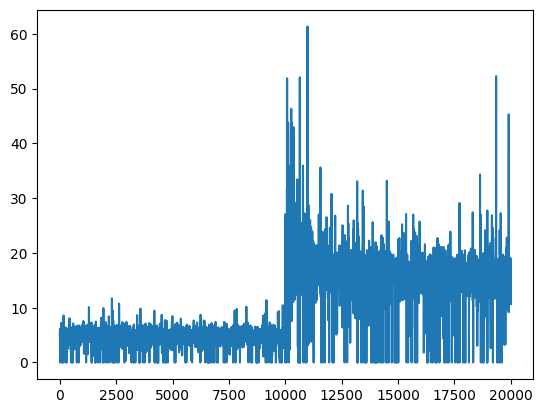

In [17]:
lr = 2e-6
it = 10000
pbar = tqdm(range(it))
opt = torch.optim.Adam([emb], lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=100)

for i in pbar:
    opt.zero_grad()
    
    output = diffsound.model(batch, return_loss=True)
    loss = output['loss']
    
    loss.backward()
    pbar.set_postfix({"loss": loss.item()})
    history.append(loss.item())
    scheduler.step(loss)
    
plt.plot(history)
plt.show()

In [18]:
scheduler.state_dict()['_last_lr']

[2e-09]

In [19]:
wav_path = diffsound.inference_generate_sample_with_text_emb(text_emb=emb, truncation_rate=0.85, 
                                                             replicate=replication, save_root=save_path, 
                                                             inference_name=None, fast=False, name='optimized')
ipd.Audio(wav_path, rate=22050)

100%|██████████| 10/10 [00:04<00:00,  2.48it/s]


In [21]:
# Save
state_dict = {'model': diffsound.model.state_dict()}
torch.save(state_dict, os.path.join(save_path, 'step_1_ckpt.pth'))
torch.save(emb, os.path.join(save_path, 'optimized.pt'))

## 2. Fine tune the model

In [9]:
diffsound = Diffsound(config=config_path, path=os.path.join(save_path, 'step_1_ckpt.pth'), ckpt_vocoder=ckpt_vocoder)
emb = torch.load(os.path.join(save_path, 'optimized.pt'))

caps_text.yaml
Restored from ../../diffsound/last.ckpt


/home/yoonjin/anaconda3/envs/ttss2/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


{'overall': {'trainable': '494.72M', 'non_trainable': '0', 'total': '494.72M'}, 'content_codec': {'trainable': '68.61M', 'non_trainable': '0', 'total': '68.61M'}, 'condition_codec': {'trainable': '0', 'non_trainable': '0', 'total': '0'}, 'transformer': {'trainable': '426.11M', 'non_trainable': '0', 'total': '426.11M'}, 'first_stage_permuter': {'trainable': '0', 'non_trainable': '0', 'total': '0'}}
Model missing keys:
 []
Model unexpected keys:
 []


In [27]:
emb.requires_grad = False
diffsound.model.train()

lr = 1e-6
opt = torch.optim.Adam(diffsound.model.parameters(), lr=lr)
# scheduler = CosineAnnealingWarmUpRestarts(opt, T_0=150, T_mult=1, eta_max=0.1,  T_up=10, gamma=0.5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, 'min', patience=100)
criteria = torch.nn.MSELoss()
history = []

100%|██████████| 5000/5000 [17:24<00:00,  4.79it/s, loss=10.8]    


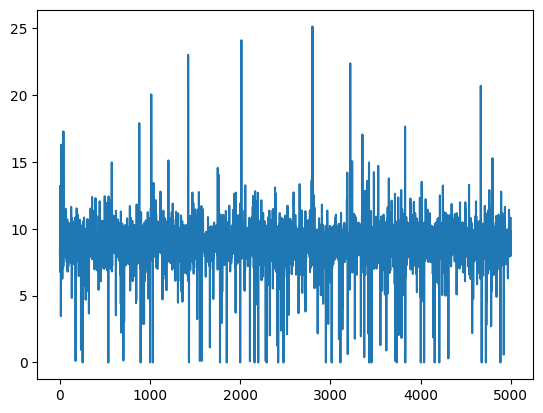

In [28]:
it = 5000
pbar = tqdm(range(it))
for i in pbar:
    opt.zero_grad()
    
    output = diffsound.model(batch, return_loss=True)
    loss = output['loss']
    
    loss.backward()
    pbar.set_postfix({"loss": loss.item()})
    history.append(loss.item())
    scheduler.step(loss)

plt.plot(history)
plt.show()

In [29]:
wav_path = diffsound.inference_generate_sample_with_text_emb(text_emb=emb, truncation_rate=0.85, 
                                                             replicate=replication, save_root=save_path, 
                                                             inference_name=None, fast=False, name='finetuned')
ipd.Audio(wav_path, rate=22050)

100%|██████████| 10/10 [00:02<00:00,  3.35it/s]


In [30]:
# Save
state_dict = {'model': diffsound.model.state_dict()}
torch.save(state_dict, os.path.join(save_path, 'step_2_ckpt.pth'))

## 3. Interpolate

In [9]:
diffsound = Diffsound(config=config_path, path=os.path.join(save_path, 'step_2_ckpt.pth'), ckpt_vocoder=ckpt_vocoder)
emb = torch.load(os.path.join(save_path, 'optimized.pt'))

caps_text.yaml
Restored from ../../diffsound/last.ckpt


/home/yoonjin/anaconda3/envs/ttss2/lib/python3.8/site-packages/torchvision/transforms/transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


{'overall': {'trainable': '494.72M', 'non_trainable': '0', 'total': '494.72M'}, 'content_codec': {'trainable': '68.61M', 'non_trainable': '0', 'total': '68.61M'}, 'condition_codec': {'trainable': '0', 'non_trainable': '0', 'total': '0'}, 'transformer': {'trainable': '426.11M', 'non_trainable': '0', 'total': '426.11M'}, 'first_stage_permuter': {'trainable': '0', 'non_trainable': '0', 'total': '0'}}
Model missing keys:
 []
Model unexpected keys:
 []


100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


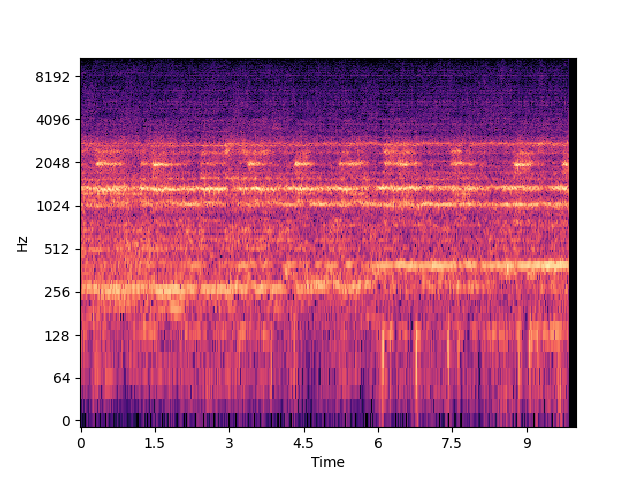

In [75]:
alpha = 0.65
new_emb = alpha*target_emb + (1-alpha)*emb
wav_path = diffsound.inference_generate_sample_with_text_emb(text_emb=new_emb, truncation_rate=0.85, 
                                                             replicate=1, save_root=save_path, 
                                                             inference_name=None, fast=False, name=f'edited_{alpha}')

ipd.display(ipd.Audio(wav_path, rate=22050))
ipd.display(ipd.Image(wav_path.replace('.wav', '.png')))